# 03 - Kaiser-Squires: Physics and Practice

## Learning Objectives

By the end of this tutorial, you should be able to:

1. Explain what the Kaiser-Squires (KS) inversion is reconstructing physically.
2. Connect core KS assumptions to practical analysis choices in SMPy.
3. Run KS in SMPy and interpret E/B maps, including smoothing tradeoffs.

## Canonical Reference

The foundational paper for this method is:

- **Kaiser, N. & Squires, G. (1993)**, *Mapping the dark matter with weak gravitational lensing*, *The Astrophysical Journal*, **404**, 441-450.  
  DOI: [10.1086/172297](https://doi.org/10.1086/172297)  
  ADS: [1993ApJ...404..441K](https://ui.adsabs.harvard.edu/abs/1993ApJ...404..441K/abstract)

## 1) Physics Primer

Weak lensing maps how light from background galaxies is distorted by foreground mass.

The local lensing distortion is described by the Jacobian

$$
\mathbf{A}(\boldsymbol{\theta}) =
\begin{pmatrix}
1-\kappa-\gamma_1 & -\gamma_2 \\
-\gamma_2 & 1-\kappa+\gamma_1
\end{pmatrix}
$$

where:

- $\kappa$: convergence (projected surface-density contrast)
- $\gamma_1, \gamma_2$: shear components

Observed galaxy shapes estimate the **reduced shear**:

$$
\mathbf{g} = \frac{\boldsymbol{\gamma}}{1-\kappa}
$$

In the weak regime ($|\kappa| \ll 1$), we often use $\mathbf{g} \approx \boldsymbol{\gamma}$.


## 2) KS Inversion in Fourier Space

Define complex shear and convergence:

$$
\gamma = \gamma_1 + i\gamma_2,
\qquad
\kappa = \kappa_E + i\kappa_B
$$

Kaiser-Squires uses the Fourier-space relation

$$
\hat{\gamma}(\boldsymbol{\ell}) = D(\boldsymbol{\ell})\,\hat{\kappa}(\boldsymbol{\ell}),
\qquad
D(\boldsymbol{\ell}) = \frac{\ell_1^2 - \ell_2^2 + 2i\ell_1\ell_2}{\ell_1^2 + \ell_2^2}
$$

So the inversion is

$$
\hat{\kappa}(\boldsymbol{\ell}) = D^*(\boldsymbol{\ell})\,\hat{\gamma}(\boldsymbol{\ell})
$$

The real part gives **E-mode** convergence (physical lensing signal), while the imaginary part gives **B-mode** (often used as a systematics diagnostic).


## 3) Practical Assumptions and Caveats

Important assumptions behind basic KS usage:

- Flat-sky approximation (appropriate for modest fields of view).
- Finite survey boundaries can leak power and bias edges.
- Smoothing reduces noise but also suppresses small-scale structure.
- Mass-sheet degeneracy remains a fundamental lensing ambiguity.

This is why diagnostics (especially B-mode behavior and sensitivity to smoothing) are part of good practice.

## 4) Mapping Physics to SMPy Settings

In SMPy, the main KS-relevant controls are:

- `general.coordinate_system`: `radec` or `pixel`
- `general.radec.resolution` (or API `pixel_scale`): angular map resolution
- `methods.kaiser_squires.smoothing.sigma` (or API `smoothing`): Gaussian smoothing scale
- `general.mode`: `['E']`, `['B']`, or `['E', 'B']`

For this tutorial we will run in `radec`, produce both E and B maps, and compare multiple smoothing values.

## 5) SMPy Analysis Workflow

A standard analysis workflow in SMPy is:

1. Set data paths and shear/coordinate column names.
2. Build a `Config` from method defaults and update the run parameters.
3. Save the config for provenance, then execute `run(config)`.
4. Inspect E/B outputs and iterate on smoothing and diagnostics.


In [27]:
from pathlib import Path
import random

import numpy as np
import pandas as pd
import smpy
from IPython.display import Image, display

from smpy.config import Config
from smpy.run import run

# Set deterministic seeds for reproducible tutorial outputs.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


def find_repo_root(start: Path) -> Path:
    # Walk upward until we find the SMPy repository root markers.
    for candidate in [start, *start.parents]:
        if (candidate / "setup.py").exists() and (candidate / "smpy").is_dir():
            return candidate
    raise RuntimeError("Could not locate SMPy repository root.")


# Resolve input/output locations relative to the repository root.
repo_root = find_repo_root(Path.cwd().resolve())
data_file = repo_root / "examples" / "data" / "forecast_lum_annular.fits"
artifacts_dir = repo_root / "examples" / "outputs" / "tutorials"
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Print runtime context for quick verification in notebook output.
print(f"SMPy version: {smpy.__version__}")
print(f"Seed: {SEED}")
print(f"Input data: {data_file}")
print(f"Output root: {artifacts_dir}")


SMPy version: 0.5.0
Seed: 42
Input data: /Users/vassig/research/SMPy/examples/data/forecast_lum_annular.fits
Output root: /Users/vassig/research/SMPy/examples/outputs/tutorials


In [28]:
base_name = "tutorial03_ks_workflow"

workflow_config = Config.from_defaults("kaiser_squires")
workflow_config.update_from_kwargs(
    data=str(data_file),
    coord_system="radec",
    pixel_scale=0.4,
    smoothing=2.0,
    g1_col="g1_Rinv",
    g2_col="g2_Rinv",
    weight_col="weight",
    mode=["E", "B"],
    save_plots=True,
    save_fits=False,
    output_dir=str(artifacts_dir),
    output_base_name=base_name,
)

workflow_config_path = artifacts_dir / "tutorial03_ks_workflow.yaml"
workflow_config.save_config(workflow_config_path)

result = run(workflow_config)

print("KS workflow run complete.")
print("E map shape:", result["maps"]["E"].shape)
print("B map shape:", result["maps"]["B"].shape)
print("E std:", float(np.nanstd(result["maps"]["E"])))
print("B std:", float(np.nanstd(result["maps"]["B"])))
print("Saved config snapshot:", workflow_config_path)


Configuration saved to: /Users/vassig/research/SMPy/examples/outputs/tutorials/tutorial03_ks_workflow.yaml
Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_workflow_kaiser_squires_e_mode.png
Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_workflow_kaiser_squires_b_mode.png
KS workflow run complete.
E map shape: (38, 57)
B map shape: (38, 57)
E std: 0.04287568259826704
B std: 0.03868921282648928
Saved config snapshot: /Users/vassig/research/SMPy/examples/outputs/tutorials/tutorial03_ks_workflow.yaml


Baseline SMPy plot outputs:
- /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_workflow_kaiser_squires_e_mode.png
- /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_workflow_kaiser_squires_b_mode.png


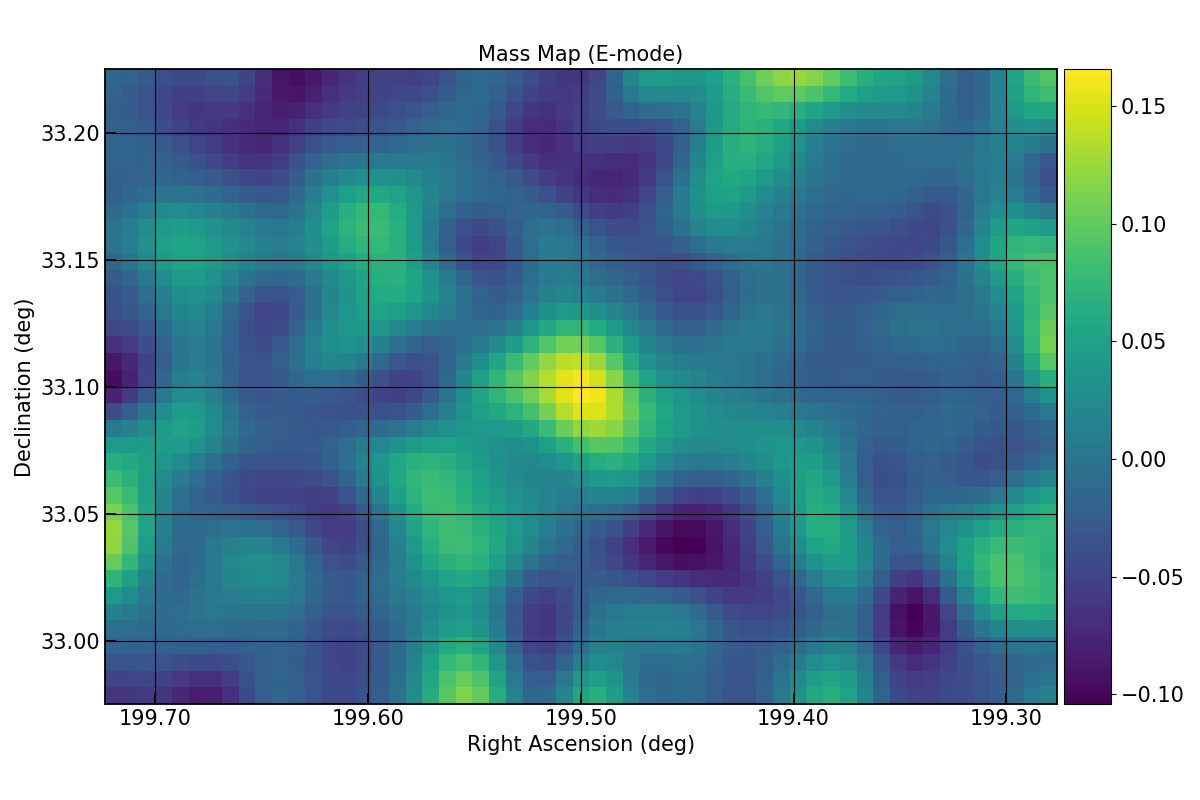

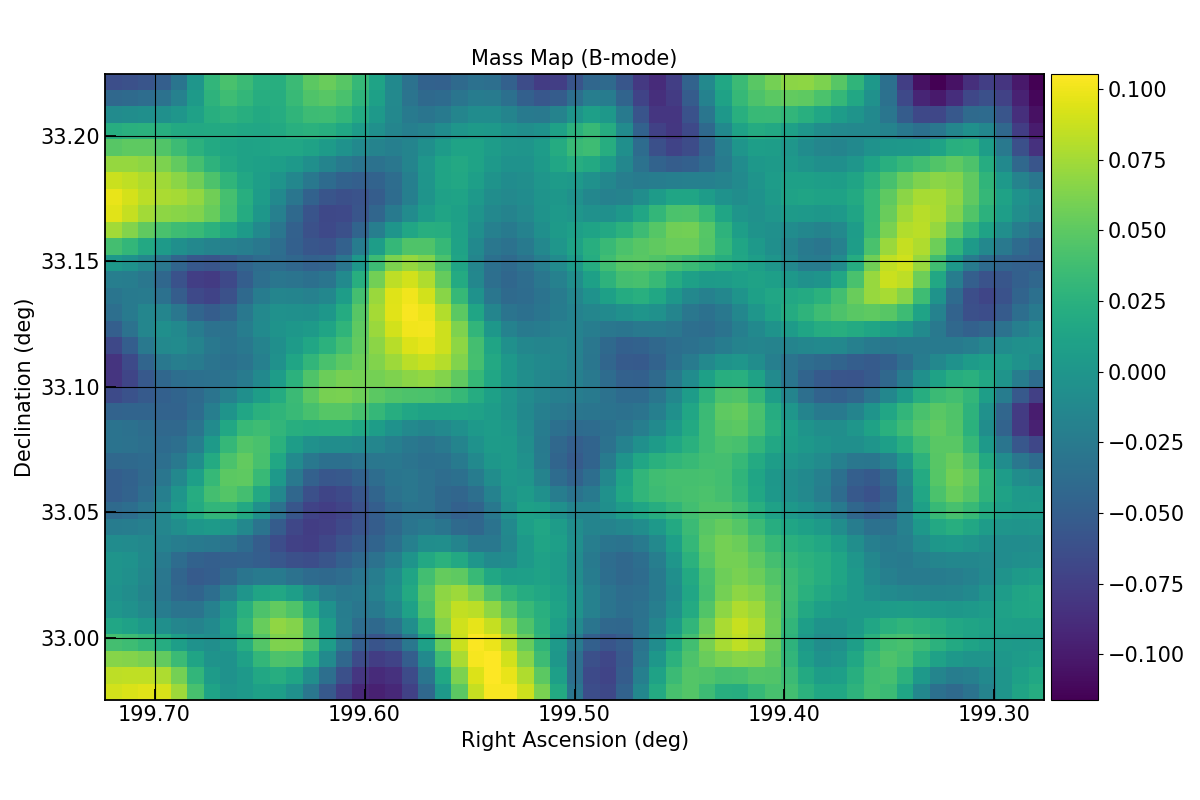

In [29]:
ks_dir = artifacts_dir / "kaiser_squires"
baseline_e_png = ks_dir / f"{base_name}_kaiser_squires_e_mode.png"
baseline_b_png = ks_dir / f"{base_name}_kaiser_squires_b_mode.png"

print("Baseline SMPy plot outputs:")
print("-", baseline_e_png)
print("-", baseline_b_png)

if baseline_e_png.exists() and baseline_b_png.exists():
    display(Image(filename=str(baseline_e_png)))
    display(Image(filename=str(baseline_b_png)))
else:
    print("Expected PNG outputs were not found. Re-run the previous cell.")

### Interpretation (Baseline)

- The E-mode map is your primary mass-reconstruction product.
- The B-mode should generally be weaker and less spatially coherent than E-mode.
- A B-mode of similar strength/structure to E-mode is a warning sign to investigate systematics.

For parameter studies, the next section uses the Config API to run a controlled smoothing sweep.


In [30]:
smoothing_values = [1.0, 2.0, 4.0]
rows = []
run_records = []

for sigma in smoothing_values:
    sigma_tag = str(sigma).replace(".", "p")
    run_name = f"tutorial03_ks_sigma{sigma_tag}"

    cfg = Config.from_defaults("kaiser_squires")
    cfg.update_from_kwargs(
        data=str(data_file),
        coord_system="radec",
        pixel_scale=0.4,
        smoothing=sigma,
        g1_col="g1_Rinv",
        g2_col="g2_Rinv",
        weight_col="weight",
        mode=["E", "B"],
        save_plots=True,
        save_fits=False,
        output_dir=str(artifacts_dir),
        output_base_name=run_name,
    )

    cfg.validate()
    res = run(cfg)

    e_map = res["maps"]["E"]
    b_map = res["maps"]["B"]

    rows.append(
        {
            "smoothing_sigma": sigma,
            "E_std": float(np.nanstd(e_map)),
            "B_std": float(np.nanstd(b_map)),
            "E_max_abs": float(np.nanmax(np.abs(e_map))),
            "B_max_abs": float(np.nanmax(np.abs(b_map))),
            "B_to_E_std_ratio": float(np.nanstd(b_map) / np.nanstd(e_map)),
        }
    )

    run_records.append(
        {
            "sigma": sigma,
            "run_name": run_name,
            "e_png": ks_dir / f"{run_name}_kaiser_squires_e_mode.png",
            "b_png": ks_dir / f"{run_name}_kaiser_squires_b_mode.png",
        }
    )

summary = pd.DataFrame(rows).sort_values("smoothing_sigma")
summary_path = artifacts_dir / "ks_smoothing_summary.csv"
summary.to_csv(summary_path, index=False)

print(f"Saved summary table: {summary_path}")
summary

Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_sigma1p0_kaiser_squires_e_mode.png
Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_sigma1p0_kaiser_squires_b_mode.png
Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_sigma2p0_kaiser_squires_e_mode.png
Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_sigma2p0_kaiser_squires_b_mode.png
Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_sigma4p0_kaiser_squires_e_mode.png
Convergence map saved as PNG file: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_sigma4p0_kaiser_squires_b_mode.png
Saved summary table: /Users/vassig/research/SMPy/examples/outputs/tutorials/

,smoothing_sigma,E_std,B_std,E_max_abs,B_max_abs,B_to_E_std_ratio
0,1.0,0.079732,0.079208,0.339032,0.287085,0.993431
1,2.0,0.042876,0.038689,0.165443,0.116255,0.902358
2,4.0,0.021592,0.016111,0.069374,0.061914,0.746153


E-mode outputs across smoothing values:
sigma=1.0: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_sigma1p0_kaiser_squires_e_mode.png


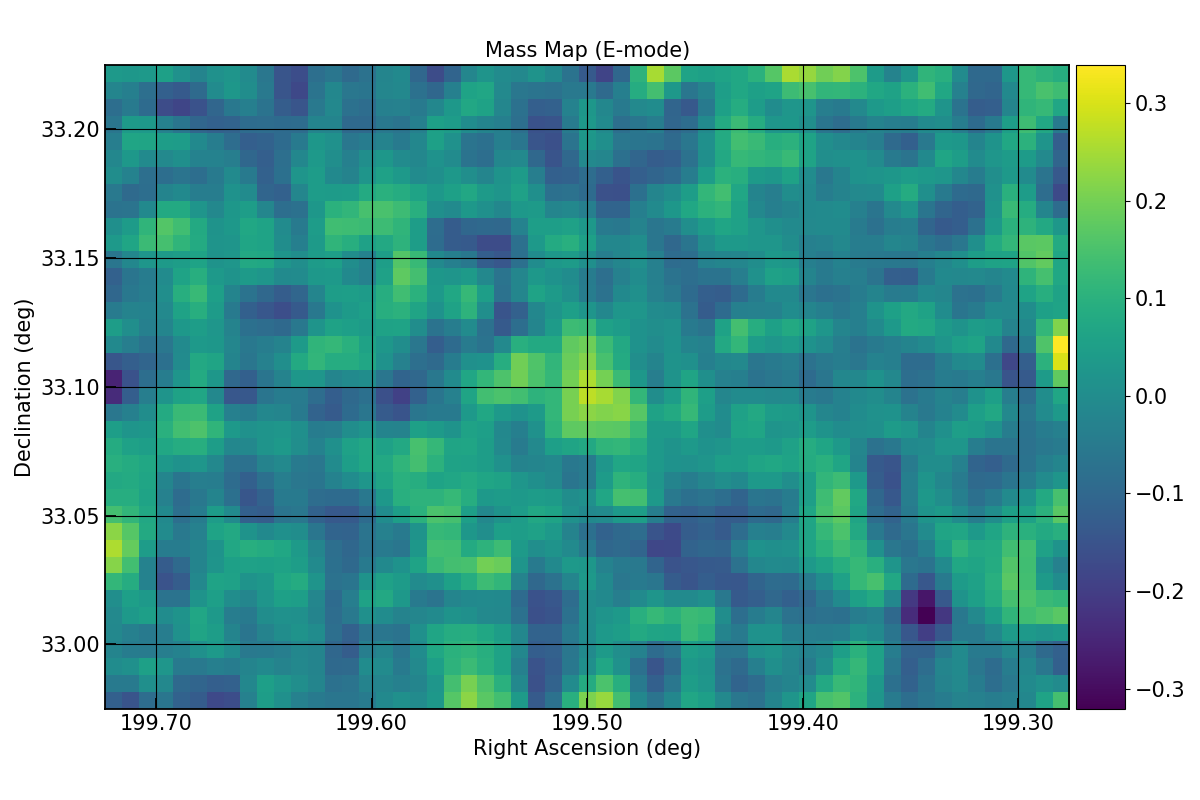

sigma=2.0: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_sigma2p0_kaiser_squires_e_mode.png


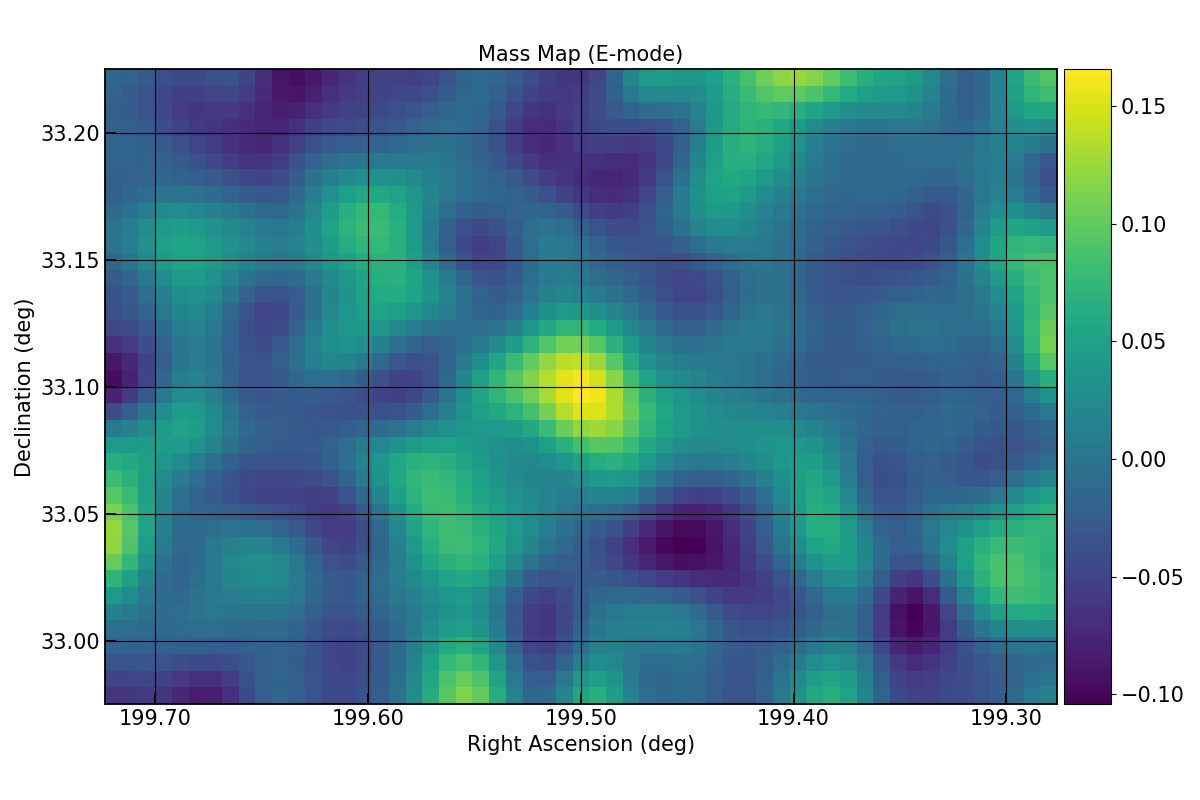

sigma=4.0: /Users/vassig/research/SMPy/examples/outputs/tutorials/kaiser_squires/tutorial03_ks_sigma4p0_kaiser_squires_e_mode.png


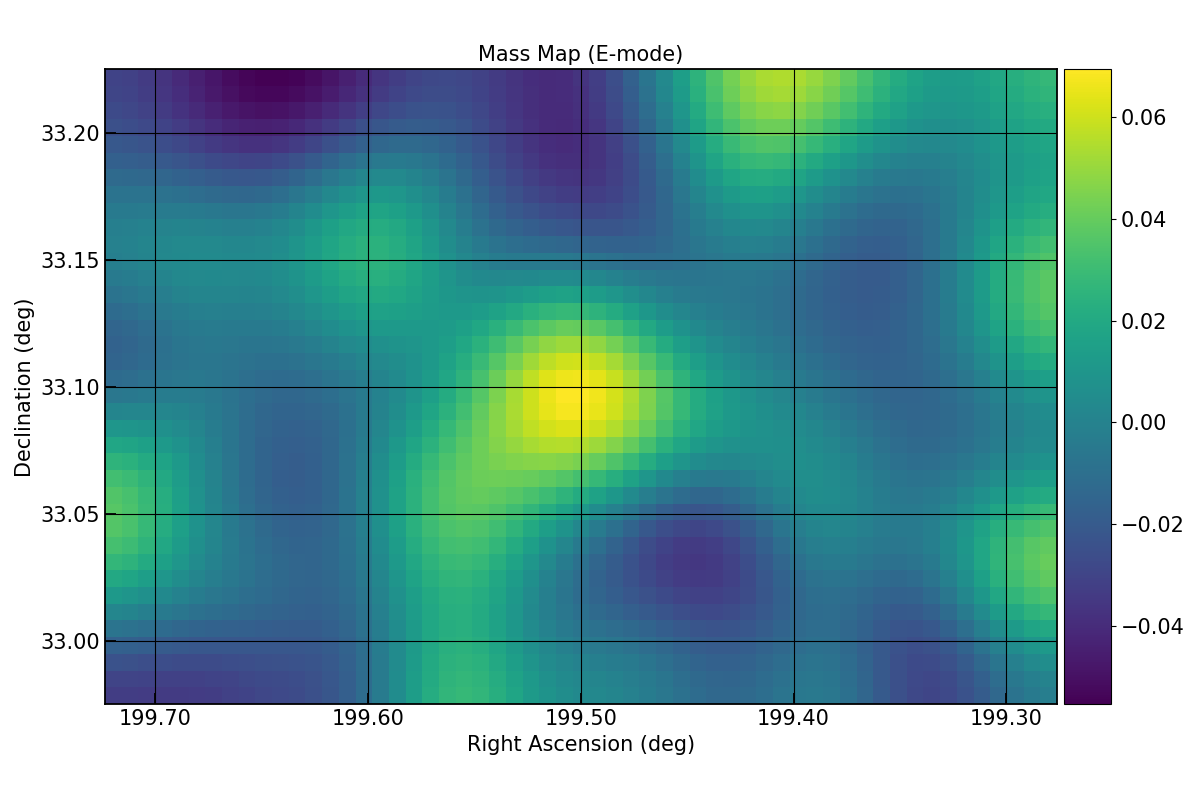

In [31]:
print("E-mode outputs across smoothing values:")
for record in run_records:
    print(f"sigma={record['sigma']}: {record['e_png']}")
    if record["e_png"].exists():
        display(Image(filename=str(record["e_png"])))
    else:
        print("  Missing file; rerun smoothing cell above.")

## References

- Kaiser, N. & Squires, G. (1993), *The Astrophysical Journal*, **404**, 441-450. DOI: [10.1086/172297](https://doi.org/10.1086/172297)
- ADS entry: [1993ApJ...404..441K](https://ui.adsabs.harvard.edu/abs/1993ApJ...404..441K/abstract)